In [ ]:
from fastai2.basics import *
from fastai2.callback.all import *
from fastai2.vision.all import *
from fastai2.medical.imaging import *

import pydicom

import pandas as pd

In [ ]:
from nbdev.showdoc import *

# Tutorial - Training X-rays on CheXNet

> Training the CheXNet on the public NHS chest X-ray dataset

## Import X-rays

### Loading the data with `Datasets`

To load the data with the medium-level API `Datasets`, we need to gather all the images and define some way to split them between training and validation sets.

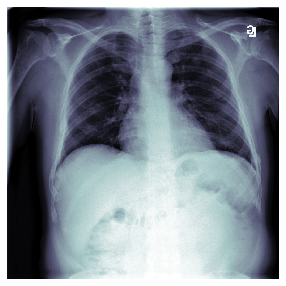

In [ ]:
patient0  = pydicom.dcmread('/home/moritz/Documents/Xray DICOM creation/dicom/00000001_000.dcm', force=True)
TEST_DCM = Path('/home/moritz/Documents/thorax-xrays/ID_87e4ef29d.dcm')
dcm = TEST_DCM.dcmread()
dcm.show()

In [ ]:
items = get_dicom_files("/home/moritz/Documents/thorax-xrays/")
trn,val = RandomSplitter()(items)
trn

(#2564) [1554,194,1573,2437,116,1744,2663,1153,1094,2037...]

Then we detail the type transforms (applied to the items to form a tuple) and the dataset transforms. For our inputs we use `PILImage.create` and for our targets, the `parent_label` function to convert a filename to its class, followed by `Categorize`. We'll also map the wordnet category ids used in Imagenette to words.

The dataset transforms contain data augmentation using PIL and a resize to 128.

In [ ]:
df = pd.read_csv("/home/moritz/Documents/siim/train-rle.csv")
df['Pneumothorax'] = 1
df.loc[df[' EncodedPixels'] == "-1", 'Pneumothorax'] = 0
df['Folder'] = df['ImageId']
#df = df[['ImageId', 'Pneumothorax']]
df.head()

,ImageId,EncodedPixels,Pneumothorax,Folder
0,1.2.276.0.7230010.3.1.4.8323329.6904.1517875201.850819,-1,0,1.2.276.0.7230010.3.1.4.8323329.6904.1517875201.850819
1,1.2.276.0.7230010.3.1.4.8323329.13666.1517875247.117800,557374 2 1015 8 1009 14 1002 20 997 26 990 32 985 38 980 42 981 42 979 43 978 45 976 47 964 59 956 66 925 98 922 101 917 106 916 106 916 107 914 109 909 113 907 116 904 118 903 120 902 120 902 121 900 122 899 124 898 124 898 125 897 125 898 125 896 126 895 127 895 128 895 128 895 128 894 128 895 128 895 128 895 128 895 128 895 128 894 130 893 130 893 130 893 130 893 129 894 129 894 129 894 129 895 127 897 126 898 126 898 125 898 126 898 125 899 125 899 125 899 124 900 124 900 125 899 125 899 125 899 125 899 126 898 127 897 128 897 128 896 129 895 130 894 132 892 133 891 134 890 136 888 137...,1,1.2.276.0.7230010.3.1.4.8323329.13666.1517875247.117800
2,1.2.276.0.7230010.3.1.4.8323329.11028.1517875229.983789,-1,0,1.2.276.0.7230010.3.1.4.8323329.11028.1517875229.983789
3,1.2.276.0.7230010.3.1.4.8323329.10366.1517875223.393986,514175 10 1008 29 994 30 993 32 991 33 990 34 989 35 988 36 988 36 989 35 989 35 989 35 988 37 986 38 985 40 983 42 982 44 980 50 974 52 972 54 970 54 969 56 968 56 968 56 968 57 967 57 966 58 966 58 966 59 964 60 964 59 964 60 964 59 964 60 964 60 963 60 964 59 964 60 963 60 964 59 964 60 964 59 965 58 966 57 966 57 967 56 968 55 969 54 970 53 971 52 971 53 971 52 972 52 972 51 973 50 975 48 976 47 977 46 978 45 979 45 979 45 979 45 979 44 980 44 980 43 981 43 982 41 983 41 983 41 983 41 984 40 984 40 984 40 985 39 985 39 985 39 986 38 986 39 985 39 986 38 986 38 986 39 986 38 986 38 986 ...,1,1.2.276.0.7230010.3.1.4.8323329.10366.1517875223.393986
4,1.2.276.0.7230010.3.1.4.8323329.10016.1517875220.992175,592184 33 976 58 956 73 941 88 926 102 917 109 910 116 903 122 892 133 888 138 883 142 879 146 873 152 868 157 864 161 860 165 856 168 854 171 851 174 849 176 847 177 845 180 843 182 841 184 838 186 837 188 835 190 833 192 831 193 830 195 828 197 826 199 824 200 823 202 822 203 820 205 818 206 818 207 816 209 815 210 813 211 812 213 811 214 809 216 808 216 807 218 806 219 804 221 803 221 802 223 801 224 799 226 798 227 797 228 795 230 794 232 791 234 790 235 788 238 786 240 784 244 780 254 12 43 714 315 709 319 705 321 703 188 23 112 701 178 47 99 699 169 62 95 698 164 77 86 697 159 87 82 ...,1,1.2.276.0.7230010.3.1.4.8323329.10016.1517875220.992175


,image_name,tags
0,train_31112,clear primary
1,train_4300,partly_cloudy primary water
2,train_39539,clear primary water
3,train_12498,agriculture clear primary road
4,train_9320,clear primary


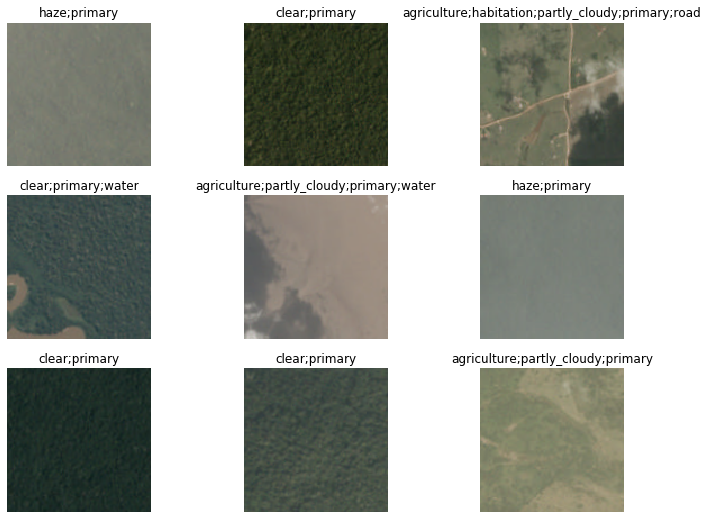

In [ ]:
pneumothorax_source = Path("/home/moritz/Documents/siim/dicom-images-train/")

pneumothorax = DataBlock(blocks=(ImageBlock(cls=PILImageBW), CategoryBlock),
                   get_x=lambda x:pneumothorax_source/f'{x[0]}/{x[0]}/{x[0]}.jpg',
                   splitter=RandomSplitter(),
                   get_y=lambda x:x[1].split(' '),
                   batch_tfms=aug_transforms(flip_vert=True, max_lighting=0.1, max_zoom=1.05, max_warp=0.))


pneumothorax_source = untar_data(URLs.PLANET_TINY)
df = pd.read_csv(planet_source/"labels.csv")

planet = DataBlock(blocks=(ImageBlock, MultiCategoryBlock),
                   get_x=lambda x:planet_source/"train"/f'{x[0]}.jpg',
                   splitter=RandomSplitter(),
                   get_y=lambda x:x[1].split(' '),
                   batch_tfms=aug_transforms(flip_vert=True, max_lighting=0.1, max_zoom=1.05, max_warp=0.))

dls = planet.dataloaders(df.values)
dls.show_batch(max_n=9, figsize=(12,9))
df.head()

In [ ]:
tfms = [[PILImage.create], [parent_label, lbl_dict.__getitem__, Categorize]]
tfms = [[PILImage.create]]
item_img_tfms = [ToTensor, FlipItem(0.5), RandomResizedCrop(128, min_scale=0.35)]

We can then pass all of this information to `Datasets`.

In [ ]:
dsets = Datasets(items, tfms, splits=split_idx)

IndexError: list index out of range

To convert our `Datasets` to a `DataLoaders`, we need to indicate the transforms we want to use at the batch level, here putting on the GPU with `Cuda`, converting the tensors of bytes to float then normalizing using the traditional imagenet statistics.

In [ ]:
batch_tfms = [IntToFloatTensor, Normalize.from_stats(*imagenet_stats)]
dls = dsets.dataloaders(after_item=item_img_tfms, after_batch=batch_tfms, bs=64, num_workers=0)

In [ ]:
items

(#13394) [Path('/home/moritz/.fastai/data/imagenette2-160/train/n03000684/n03000684_6386.JPEG'),Path('/home/moritz/.fastai/data/imagenette2-160/train/n03000684/n03000684_3359.JPEG'),Path('/home/moritz/.fastai/data/imagenette2-160/train/n03000684/n03000684_7457.JPEG'),Path('/home/moritz/.fastai/data/imagenette2-160/train/n03000684/n03000684_9113.JPEG'),Path('/home/moritz/.fastai/data/imagenette2-160/train/n03000684/n03000684_20136.JPEG'),Path('/home/moritz/.fastai/data/imagenette2-160/train/n03000684/n03000684_7636.JPEG'),Path('/home/moritz/.fastai/data/imagenette2-160/train/n03000684/n03000684_17226.JPEG'),Path('/home/moritz/.fastai/data/imagenette2-160/train/n03000684/n03000684_22434.JPEG'),Path('/home/moritz/.fastai/data/imagenette2-160/train/n03000684/n03000684_32468.JPEG'),Path('/home/moritz/.fastai/data/imagenette2-160/train/n03000684/n03000684_36449.JPEG')...]

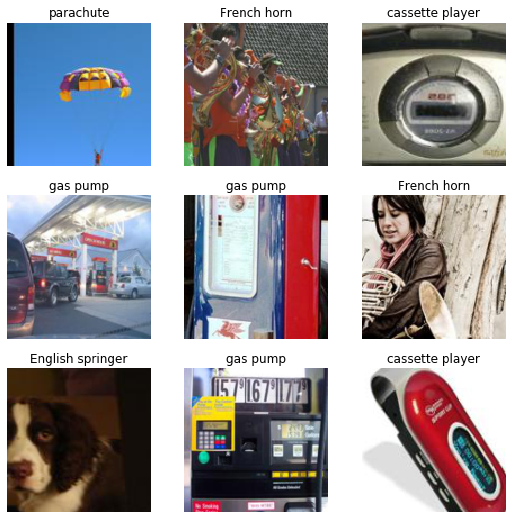

In [ ]:
dls.show_batch(max_n=9)

### Loading the data with `DataBlock`

An easier way is to use the `DataBlock` higher-level API. We just need to specify the types, how to get the items, how to split them and how to label to build an Imagenette datablock.

In [ ]:
imagenette = DataBlock(blocks=(ImageBlock, CategoryBlock), 
                       get_items=get_image_files, 
                       splitter=GrandparentSplitter(valid_name='val'),
                       get_y=[parent_label,lbl_dict.__getitem__],
                       item_tfms=item_img_tfms, 
                       batch_tfms=Normalize.from_stats(*imagenet_stats))

We can then directly call the `dataloaders` method when specifying a source (where the items are) and the non-default dataset and dataloader transforms. To check which transforms are included by default (inferred from the types passed), we can check (and potentially modify) the attributes `default_type_tfms`, `default_item_tfms` and `default_batch_tfms` of the `imagenette` object.

In [ ]:
imagenette.type_tfms,imagenette.item_tfms,imagenette.batch_tfms

((#2) [(#1) [<bound method PILBase.create of <class 'fastai2.vision.core.PILImage'>>],(#1) [Categorize: (object,object) -> encodes (object,object) -> decodes]],
 (#3) [ToTensor: (PILMask,object) -> encodes
 (PILBase,object) -> encodes ,FlipItem: (TensorBBox,object) -> encodes
 (TensorPoint,object) -> encodes
 (TensorMask,object) -> encodes
 (TensorImage,object) -> encodes
 (Image,object) -> encodes ,RandomResizedCrop: (TensorBBox,object) -> encodes
 (TensorPoint,object) -> encodes
 (Image,object) -> encodes ],
 (#2) [IntToFloatTensor: (TensorMask,object) -> encodes
 (TensorImage,object) -> encodes (TensorImage,object) -> decodes,Normalize: (TensorImage,object) -> encodes (TensorImage,object) -> decodes])

Here we need to add the data augmentation and resize, as well as the normalization.

In [ ]:
dls = imagenette.dataloaders(source, bs=64, num_workers=8)

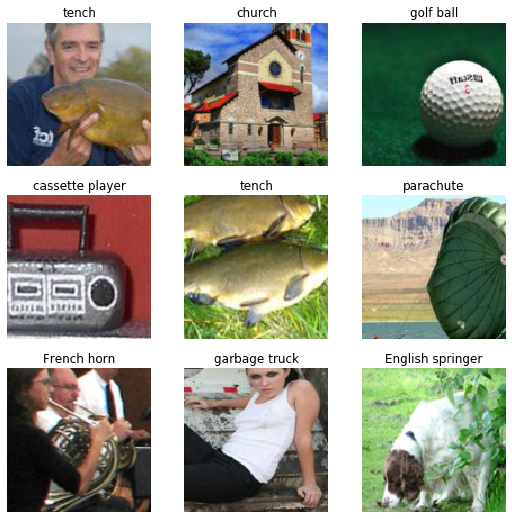

In [ ]:
dls.show_batch(max_n=9)

### Training

The following function will give us a `Learner` to train a model on imagenette.

In [ ]:
learn = Learner(dls, xresnet18(), lr=1e-2, metrics=accuracy,
                loss_func=LabelSmoothingCrossEntropy(),
                opt_func=partial(Adam, wd=0.01, eps=1e-3)
               ).to_fp16()

Then we can train our model.

In [ ]:
learn.fit_one_cycle(1)

epoch,train_loss,valid_loss,accuracy,time
0,2.364704,2.153578,0.593121,00:18


## Showing results

To get predictions on one item, we use `Learner.predict`

In [ ]:
tst_item = items[0]
t = learn.predict(tst_item)

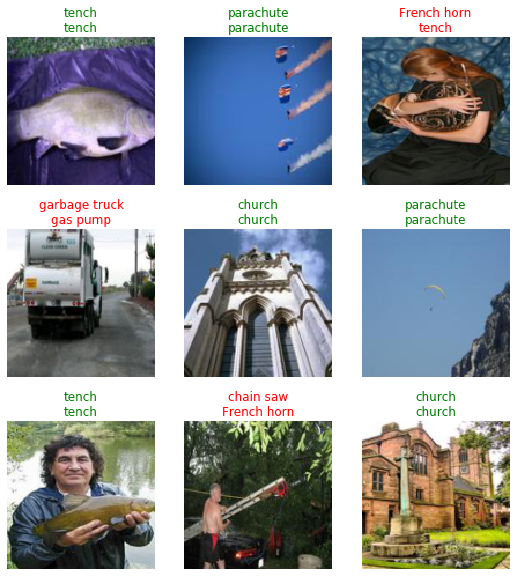

In [ ]:
learn.show_results()

### Side note: using a PyTorch optimizer

In [ ]:
@delegates(torch.optim.AdamW.__init__)
def pytorch_adamw(params, **kwargs):
    return OptimWrapper(torch.optim.AdamW(params, **kwargs))

In [ ]:
learn = Learner(dls, xresnet18(), lr=1e-2, metrics=accuracy,
                loss_func=LabelSmoothingCrossEntropy(),
                opt_func=partial(pytorch_adamw, wd=0.01, eps=1e-3)
               ).to_fp16()

## Rect training (not working well)

For a rectangular training, we change the dataset transforms to use the flip only. We will resize the images when it's time to batch them only.

In [ ]:
#img_tfms = [FlipItem(0.5)]
#tfms = [PILImage.create, [parent_label, Categorize()]]
#dsets = Datasets(items, tfms, splits=split_idx, item_tfms=img_tfms)

#tfms = [Cuda(), IntToFloatTensor(), Normalize(*imagenet_stats)]
#bs = 64

We use a sampler that will group the images by batches of the close size and aspect ratio (with a bit of shuffle for the training set) and a collation function that will resize them to the mdeian aspect ratio and median number of pixel (bound by `max_px`). `rand_min_scale` is used to do a `RandomResizedCrop` to that size on the training set.

In [ ]:
#samp = SortARSampler(dsets.train, shuffle=True, bs=bs)
#collate_fn = ResizeCollate(max_px=128*128, rand_min_scale=0.35, rand_ratio_pct=0.33, round_mult=32)
#train_dl = TfmdDL(dsets.train, tfms, num_workers=8, batch_sampler=samp, collate_fn=collate_fn)

#samp = SortARSampler(dsets.valid, shuffle=False, bs=bs)
#collate_fn = ResizeCollate(max_px=128*128, round_mult=32)
#valid_dl = TfmdDL(dsets.valid, tfms, num_workers=8, batch_sampler=samp, collate_fn=collate_fn)

Then we create a `DataLoaders` with those two dataloaders.

In [ ]:
#dls1 = imagenette.dataloaders(source, bs=64, num_workers=8, item_tfms=item_img_tfms, batch_tfms=Normalize(*imagenet_stats))

#dls = DataLoaders(train_dl, valid_dl)
#dls.show_batch(max_n=9)

In [ ]:
#learn = cnn_learner(xresnet18, dls, LabelSmoothingCrossEntropy(), opt_func=opt_func, c_in=3, c_out=10, lr=1e-2, metrics=accuracy)
#learn.fit_one_cycle(1)